# 09 - Final Evaluation and Deployment Prepartion

## 9.1 Set-up

### 9.1.1 Initial Config

In [1]:
# logger.info("Setting up root by appending the parent to the sys...")
from jupyter_init import setup

setup()

from src_code.config import *

### 9.1.2 Logger

In [2]:
from notebooks.logging_config import setup_notebook_logging

logger, log_start, log_check, log_result = setup_notebook_logging(label="ENGINEERING")

log_start(print_to_console=True)
log_result("Logging configured.", print_to_console=True)

================== Starting notebook: 09-final-eval-and-deploy-prep (Session 351) ==================
[ENGINEERING RESULT] Logging configured.


### 9.1.3 Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

### 9.1.4 Loading Testing Dataset

In [4]:
log_check("Loading the dataset...")

# TRANSFORMED_DF = EXTRACTED_DATA_DIR / "train_labeled_features_partial.feather"
DF_PATH = ENGINEERING_MAPPINGS['test']['output']

# ---- LOAD ----
df = pd.read_feather(DF_PATH)
df.describe()

[ENGINEERING CHECK] Loading the dataset...


,author_exp_pre,author_recent_activity_pre,loc_added,loc_deleted,files_changed,hunks_count,msg_len,ast_delta,complexity_delta,max_func_change,...,loc_added_bucket_cat,line_token_total,todo_ratio,fixme_ratio,try_ratio,except_ratio,raise_ratio,loc_added_x_loc_deleted,loc_added_x_hunks_count,loc_deleted_x_hunks_count
count,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,...,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000
mean,2.840142,2.444520,3.266355,3.898516,2.094760,3.417300,4.857223,2.704583,0.802345,3.994454,...,1.304360,1.231796,0.015466,0.000322,0.131721,0.049608,0.041409,14.538188,12.927895,14.801155
std,1.453951,1.339029,1.710148,1.510910,0.920425,1.213459,0.764812,2.298529,0.900588,1.485577,...,1.074951,1.805038,0.056913,0.008198,0.201134,0.131302,0.125245,10.352738,9.184485,8.877840
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.833213,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.791759,1.609438,1.945910,2.890372,1.386294,2.564949,4.174387,0.000000,0.000000,3.583519,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.165612,4.569000,7.672484
50%,2.995732,2.564949,3.465736,4.077537,1.945910,3.496508,4.859812,3.091042,0.000000,4.276666,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.678418,11.970531,14.257489
75%,3.891820,3.367296,4.804021,5.164786,2.833213,4.418841,5.517453,5.075174,1.791759,5.023881,...,2.000000,2.079442,0.000000,0.000000,0.248283,0.000000,0.000000,22.795703,20.289937,21.604479
max,5.978886,5.081404,5.433722,5.814131,3.637586,5.204007,5.985195,5.474369,2.140066,5.592851,...,3.000000,13.135453,0.616776,0.409384,1.739033,1.098612,2.397895,31.592369,28.277126,30.256774


### 9.1.5 Loading Trained Model

In [5]:
MODEL_PATH = RANDOM_FOREST_MODEL
model = joblib.load(MODEL_PATH)
print("Pipeline Steps:", model.named_steps.keys())

Pipeline Steps: dict_keys(['rf'])


## 9.2 Final Evaluation

### 9.2.1 Inference

In [8]:
# 5. Prepare Features for Prediction
# Ensure you drop non-feature columns (labels, commits, hashes) before predicting
# Replace 'label' with your actual target column name
X_test = df.drop(
    columns=[
        "label",
        "commit",
        "datetime",
        "repo",
        "author_email",
        "canonical_datetime",
        "content",
        "filepath",
        "files_changed",
        'lines',
        'loc_added_bucket',
        "methods"
    ],
    errors="ignore",
)
y_true = df["label"] if "label" in df.columns else None

# 6. Predict
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

### 9.2.2 Evaluation

In [9]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

if y_true is not None:
    print(classification_report(y_true, predictions))
    print(f"ROC-AUC Score: {roc_auc_score(y_true, probabilities):.4f}")

              precision    recall  f1-score   support

           0       0.95      0.40      0.57      6535
           1       0.15      0.83      0.25       828

    accuracy                           0.45      7363
   macro avg       0.55      0.62      0.41      7363
weighted avg       0.86      0.45      0.53      7363

ROC-AUC Score: 0.6607


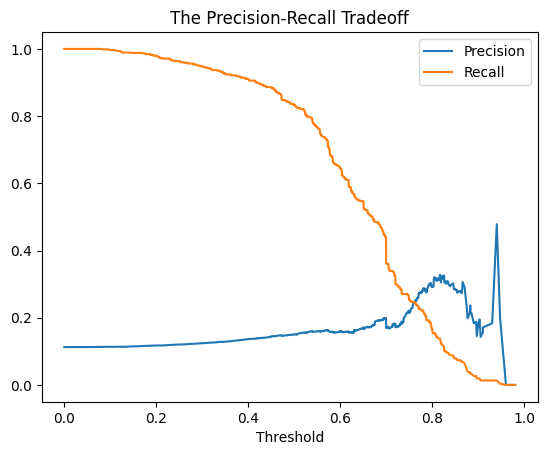

In [10]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities instead of hard predictions
probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_true, probs)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.title("The Precision-Recall Tradeoff")
plt.legend()
plt.show()

In [11]:
# Instead of predictions = model.predict(X_test)
custom_threshold = 0.75  # Found from the chart above
custom_predictions = (probs >= custom_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_true, custom_predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6535
           1       0.22      0.26      0.23       828

    accuracy                           0.81      7363
   macro avg       0.56      0.57      0.56      7363
weighted avg       0.83      0.81      0.82      7363



In [12]:
from sklearn.metrics import f1_score
import numpy as np

# Calculate F1 for every threshold produced by the PR curve
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold for F1: {best_threshold:.4f}")
print(f"Best achievable F1-Score: {f1_scores[best_idx]:.4f}")

# Apply this threshold
final_preds = (probs >= best_threshold).astype(int)
print(classification_report(y_true, final_preds))

Optimal Threshold for F1: 0.6933
Best achievable F1-Score: 0.2756
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      6535
           1       0.20      0.46      0.28       828

    accuracy                           0.73      7363
   macro avg       0.56      0.61      0.55      7363
weighted avg       0.84      0.73      0.77      7363



In [ ]:
# import pandas as pd

# # Get feature names from the preprocessor we fixed earlier
# feature_names = preprocessor.get_feature_names_out()
# importances = model.feature_importances_

# feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# print("Top 10 Most Important Features:")
# print(feat_imp.head(10))

In [13]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# 1. Get the probabilities
probs = model.predict_proba(X_test)[:, 1]

# 2. Test 100 different thresholds to find the best MCC
thresholds = np.linspace(0, 1, 100)
mcc_scores = [matthews_corrcoef(y_true, probs >= t) for t in thresholds]

# 3. Find the best one
best_threshold = thresholds[np.argmax(mcc_scores)]
best_mcc = max(mcc_scores)

print(f"Optimal Threshold for MCC: {best_threshold:.4f}")
print(f"Best MCC Score: {best_mcc:.4f}")

# 4. Generate the final report
final_predictions = (probs >= best_threshold).astype(int)
print(classification_report(y_true, final_predictions))

Optimal Threshold for MCC: 0.5354
Best MCC Score: 0.1681
              precision    recall  f1-score   support

           0       0.95      0.47      0.63      6535
           1       0.16      0.80      0.27       828

    accuracy                           0.50      7363
   macro avg       0.55      0.63      0.45      7363
weighted avg       0.86      0.50      0.59      7363

